In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from datetime import datetime, timezone, timedelta
import re

In [2]:
#user input, multiple
lakes = ["27003900", "27001600", "62007800", "62005700", "27003100"]

In [3]:
#user input, string
species = "NOP"

In [4]:
#user input, datetime64
start_date = np.datetime64("2000-01-31")

In [5]:
#user input, string, optional
gear = "Standard gill nets"

In [6]:
#read .csv files
fish_length_data = pd.read_csv(f"Resources/fish_length_info/fish_length.csv",converters={"lake_ID": str})
fish_catch_data = pd.read_csv(f"Resources/fish_catch_info/fish_catch.csv",converters={"lake_ID": str})

In [7]:
#add methods

#drop strings from cpue data series and convert to int(found some "? marks")
def cpue_cleaner(dfseries):
    i=0
    for _ in dfseries:
        try:
            np.float64(_)
            i = i + 1
        except ValueError:
            print(i, _,"valueerror")
            dfseries = dfseries.drop([i])
            i = i + 1
    dfseries = pd.to_numeric(dfseries)
    return dfseries

#sort and format year survey data then convert to datetime
def survey_date_cleaner(dfseries):
    dfseries = dfseries.copy()
    for _ in range(len(dfseries)):
        dfseries[_] = dfseries[_].replace("/","-")
        if matches := re.search(r"^(\d?\d{1})-(\d?\d{1})-(\d{4})$", dfseries[_], re.IGNORECASE):
            dfseries[_] = f"{matches.group(3)}-{matches.group(2)}-{matches.group(1)}"
        try:
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
        except ValueError:
            if matches := re.search(r"^(\d{4})-(\d?\d{1})-(\d?\d{1})$", dfseries[_], re.IGNORECASE):
                dfseries[_] = f"{matches.group(1)}-{matches.group(3)}-{matches.group(2)}"
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
    dfseries = pd.to_datetime(dfseries,format="%Y-%m-%d")
    return dfseries

#input fish_catch_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64, gear as str
#returns list of cpue column in dataframe for boxplot
def get_cpue_box(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    cpue_boxplot_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["gear"] == gear) & \
                            (df["survey_date"] >= start_date) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        cpue_boxplot_list.append(species_cpue)
    return cpue_boxplot_list

#uses a list format to plot cpue boxplots
def plot_cpue_box(fishlist, lakes):
    plt.boxplot(fishlist)
    labels = lakes
    ticks = range(1, len(lakes)+1)
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")
    plt.title(species)
    plt.show()

#input string "[[1,2], [2,13], [4,6]]"
#returns fish_count column in dataframe as a list of individual integer measurements e.g. [0,0,1,1,1,2,3,3,4]
def fish_length_cleaner(fishcount):
    fish_lengths = []
    #scrub each row string and convert to list of lengths sampled
    for row in fishcount:
        #clean up string of list syntax
        sample = row.replace("]","").replace("[","").replace(" ","").split(",")
        #breakdown string into list of lengths sampled
        for n in range(len(sample)):
            if n % 2 == 1:
                fishlength = int(sample[n-1])
                fishcount = int(sample[n])
                for c in range(fishcount):
                    fish_lengths.append(fishlength)
    return fish_lengths   

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#returns dictionary of fish_count column in dataframe for histogram, format {lake ID:[0,0,1,2,2,2,2,3,3]}
def get_length_hist(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    fish_lengths = {}
    for lakeid in lakes:
        #sort by lake and species
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "fish_count"]
        fish_lengths[lakeid] = fish_length_cleaner(species_length)
    return fish_lengths

#Uses a dictionary format {lake ID:[0,0,1,2,2,2,2,3,3]} to plot fish length histograms
def plot_length_hist(fishdict):
    for lakeid in fishdict.keys():
        if bool(fishdict[lakeid]) == False:
            print(f"{lakeid} did not return results for the timeframe or species specified.")
        else:
            plt.hist(fishdict[lakeid])
            plt.xlabel("Size in Inches")
            plt.ylabel("Number sampled")
            plt.title(f"{lakeid} {species}")
            plt.show()
            
#input string "[[1,2], [2,13], [4,6]]"
#returns fish_count column in dataframe as a list of float averages e.g. [5.1, 4.6, 8.8]
def fish_length_averager(fishcount):
    fish_length_averages = []
    for row in fishcount:
        sample = row.replace("]","").replace("[","").replace(" ","").split(",")
        #breakdown string into list of lengths found
        mean_numbers = []
        for n in range(len(sample)):
            if n % 2 == 1:
                fishlength = int(sample[n-1])
                fishcount = int(sample[n])
                for c in range(fishcount):
                    mean_numbers.append(fishlength)
        fish_length_averages.append(np.mean(mean_numbers))
    return fish_length_averages

#input cpue_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return cpue data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_cpue_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_cpue_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["survey_date"] >= start_date) & \
                            (df["gear"] == gear) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        lake_scatter_cpue_list.append(species_cpue)
    return lake_scatter_cpue_list

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return avg species length data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_avglen_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    lake_scatter_length_list = []
    for lakeid in lakes:
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "average_length"]
        lake_scatter_length_list.append(species_length)
    return lake_scatter_length_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return survey date data for scatterplot using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_survey_date_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_survey_date_list = []
    for lakeid in lakes:
        try:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]
        except KeyError:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]            
        lake_scatter_survey_date_list.append(species_survey_date)
    return lake_scatter_survey_date_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return numeric survey date data for regression line using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_numeric_survey_date_regress(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_numeric_survey_date_list = []
    for lakeid in lakes:
        try:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]
        except KeyError:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]            
        lake_scatter_numeric_survey_date_list.append(lake_scatter_numeric_survey_date)
    return lake_scatter_numeric_survey_date_list

#input fish= length or cpue series int, sdate= survey date series datetime64, lakes= [list of lake id], ytext= ylabel value
#scatter plot average lengths per lake
def plot_scatter(fish, sdate, lakes, ytext=""):
    for _ in range(len(lakes)):
        plt.scatter(sdate[_],fish[_], label=lakes[_])
    plt.title(species)
    plt.ylabel(f"{ytext}")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.show()
    
#plot regression lines with scatter plots for each lake
def plot_regression_scatter(fish, sdate, ndate, lakes, ytext=""):
    print("Notes:")
    for lake in range(len(lakes)):
        if len(ndate[lake]) == 0:
            print(f"Survey Data Empty for {lakes[lake]}")
        elif len(ndate[lake]) == 1:
            print(f"Only 1 data point exists for {lakes[lake]}")
        else:
            regression_values = linregress(ndate[lake],fish[lake])
            fig, ax1 = plt.subplots(1,1)
            fig.suptitle(lakes[lake])
            ax1.scatter(sdate[lake],fish[lake], label=lakes[lake])
            ax1.set_ylabel(f"{species} {ytext}")
            ax1.set_xlabel(f"R value = {regression_values.rvalue}")
            plt.xticks(rotation=45)
            ax2 = ax1.twiny()
            ax2.plot(ndate[lake],(regression_values.slope*ndate[lake] + regression_values.intercept))
    plt.show()

In [8]:
#add numeric survey date column as an integer to fish CPUE
fish_catch_df = fish_catch_data
fish_catch_df["survey_date"] = survey_date_cleaner(fish_catch_df["survey_date"])
fish_catch_df["survey_date"] = pd.to_datetime(fish_catch_df["survey_date"],format="%Y-%m-%d")
fish_catch_df["numeric_survey_date"] = pd.to_numeric(fish_catch_df["survey_date"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df = fish_catch_df.reset_index(drop=True)
fish_catch_df.head()

,lake_ID,CPUE,averageWeight,gear,gearCount,quartileCount,quartileWeight,species,survey_ID,survey_date,totalCatch,totalWeight,numeric_survey_date
0,10004200,1.75,3.64,Standard trap nets,4.0,NaN,NaN,NOP,121577.0,1940-06-24,7,25.50,-931651200000000000
1,10004200,16.50,0.15,Standard gill nets,2.0,2.0-22.3,0.1-0.2,YEP,121577.0,1940-06-24,33,4.80,-931651200000000000
2,10004200,0.25,1.25,Standard trap nets,4.0,0.2-0.8,0.3-1.5,LMB,121577.0,1940-06-24,1,1.25,-931651200000000000
3,10004200,1.00,0.11,Standard trap nets,4.0,0.7-6.5,0.1-0.2,PMK,121577.0,1940-06-24,4,0.45,-931651200000000000
4,10004200,21.00,0.20,Standard trap nets,4.0,3.5-57.1,0.1-0.3,BLG,121577.0,1940-06-24,84,16.50,-931651200000000000


In [9]:
#add numeric survey date column as an integer to fish length
fish_length_df = fish_length_data
fish_length_df["survey_date"] = survey_date_cleaner(fish_length_df["survey_date"])
fish_length_df["survey_date"] = pd.to_datetime(fish_length_df["survey_date"],format="%Y-%m-%d")
fish_length_df["numeric_survey_date"] = pd.to_numeric(fish_length_df["survey_date"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df = fish_length_df.reset_index(drop=True)
fish_length_df.head()

,lake_ID,species,fish_count,maximum_length,minimum_length,survey_ID,survey_date,numeric_survey_date
0,62006700,BIB,"[[0, 1]]",0,0,120236.0,1953-09-01,-515462400000000000
1,62006700,GSF,"[[0, 1]]",0,0,120236.0,1953-09-01,-515462400000000000
2,62006700,WTS,"[[0, 1]]",0,0,120236.0,1953-09-01,-515462400000000000
3,62006700,BLG,"[[0, 1]]",0,0,120236.0,1953-09-01,-515462400000000000
4,62006700,CAP,"[[0, 1]]",0,0,120236.0,1953-09-01,-515462400000000000


In [10]:
#add average length column to length dataframe
fish_length_averages = fish_length_averager(fish_length_df["fish_count"])
fish_length_df["average_length"] = pd.Series(fish_length_averages)

In [11]:
#clean the CPUE series
fish_catch_df["CPUE"] = cpue_cleaner(fish_catch_df["CPUE"])

52815 ? valueerror
59251 ? valueerror
65033 ? valueerror
78472 ? valueerror
78510 ? valueerror
78515 ? valueerror
78537 ? valueerror
95667 ? valueerror
96327 ? valueerror
96339 ? valueerror
96358 ? valueerror
96477 ? valueerror
96620 ? valueerror
96642 ? valueerror
96838 ? valueerror
96922 ? valueerror
97385 ? valueerror
97389 ? valueerror
97424 ? valueerror
99481 ? valueerror
99653 ? valueerror
100058 ? valueerror
100059 ? valueerror
100502 ? valueerror
100646 ? valueerror
100979 ? valueerror
101002 ? valueerror
101574 ? valueerror
101595 ? valueerror
101930 ? valueerror
102321 ? valueerror
102661 ? valueerror
103071 ? valueerror
103665 ? valueerror
103708 ? valueerror
103933 ? valueerror
105284 ? valueerror
105292 ? valueerror
105293 ? valueerror
106084 ? valueerror
106159 ? valueerror
106161 ? valueerror
106349 ? valueerror
106371 ? valueerror
106735 ? valueerror
106922 ? valueerror
106945 ? valueerror
107017 ? valueerror
107024 ? valueerror
107525 ? valueerror
108069 ? valueerror
1

In [12]:
#create date series for length scatter plots and regression lines
length_sdate = get_survey_date_scatter(fish_length_df, lakes, species, start_date)
length_ndate = get_numeric_survey_date_regress(fish_length_df, lakes, species, start_date)

In [13]:
#create date series for cpue scatter plots and regression lines
cpue_sdate = get_survey_date_scatter(fish_catch_df, lakes, species, start_date)
cpue_ndate = get_numeric_survey_date_regress(fish_catch_df, lakes, species, start_date)

In [14]:
#filter and prepare a CPUE list for box plots
cpuelist = get_cpue_box(fish_catch_df, lakes, species, start_date)

In [15]:
#filter and prepare a list of lengths for histogram plots
lengthdict = get_length_hist(fish_length_df, lakes, species, start_date)

In [16]:
#create fish CPUE data series for scatter plot and regression line
fish_cpue = get_cpue_scatter(fish_catch_df, lakes, species, start_date)

In [17]:
#create fish length data series for scatter plot and regression line
fishavglength = get_avglen_scatter(fish_length_df, lakes, species, start_date)

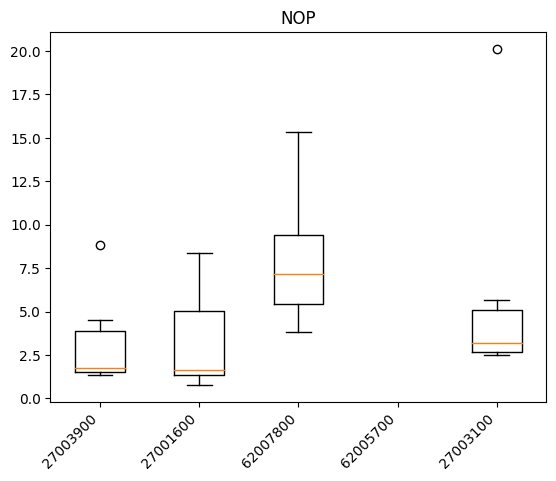

In [18]:
#plot boxplot of CPUE per lake
plot_cpue_box(cpuelist, lakes)

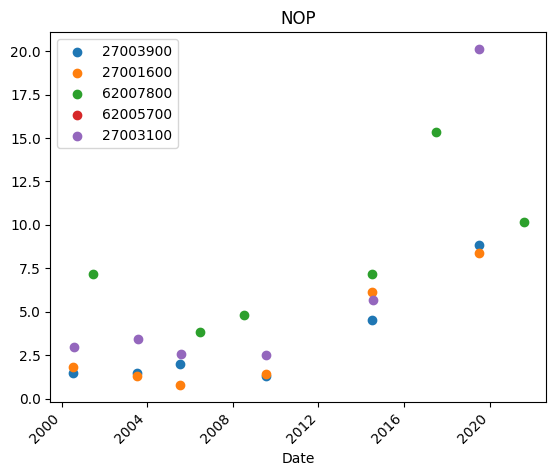

In [19]:
#plot scatter of CPUE per lake
plot_scatter(fish_cpue, cpue_sdate, lakes)

Notes:
Survey Data Empty for 62005700


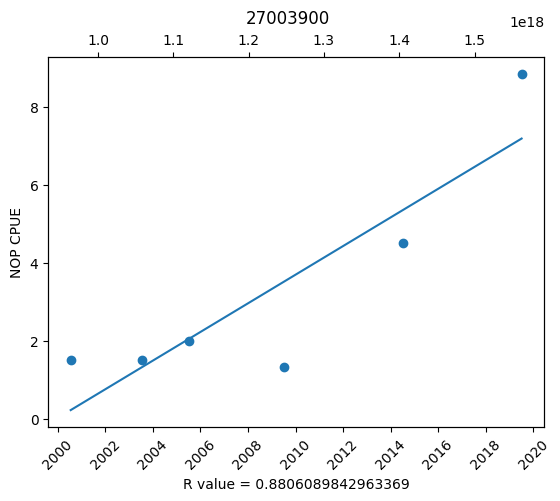

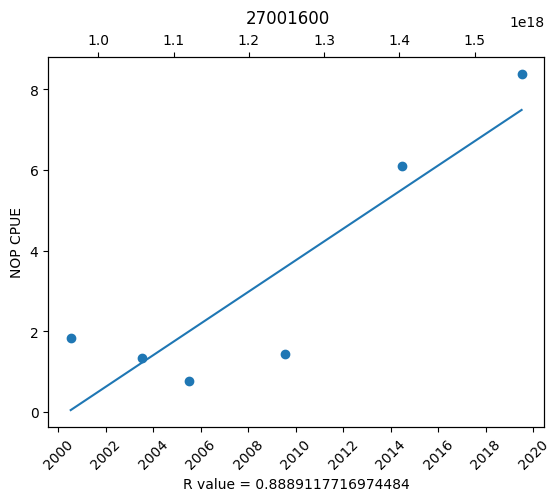

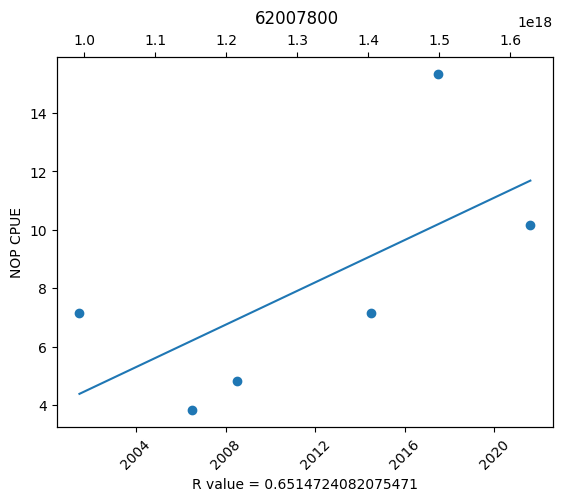

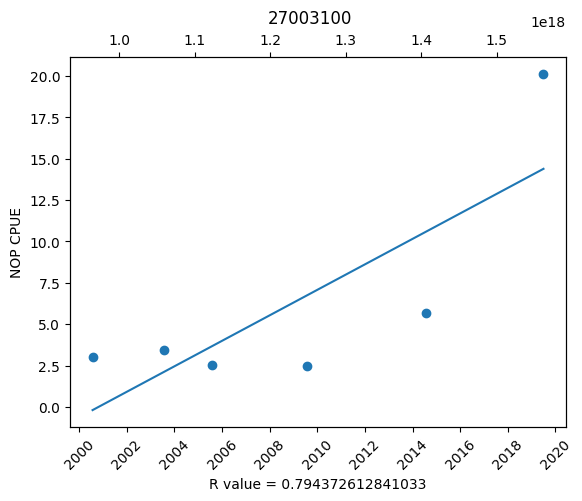

In [20]:
#plot regression lines for each lake CPUE over time
plot_regression_scatter(fish_cpue, cpue_sdate, cpue_ndate, lakes, "CPUE")

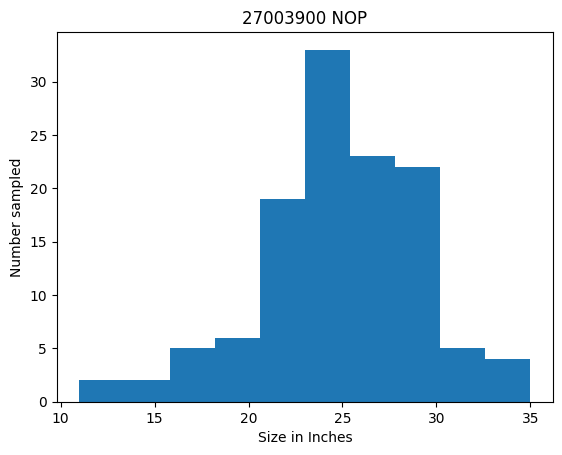

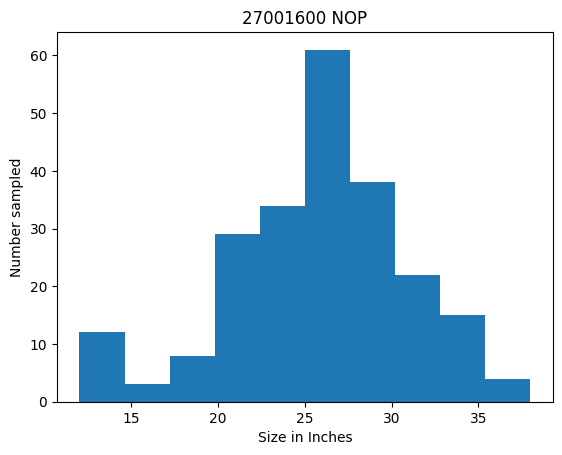

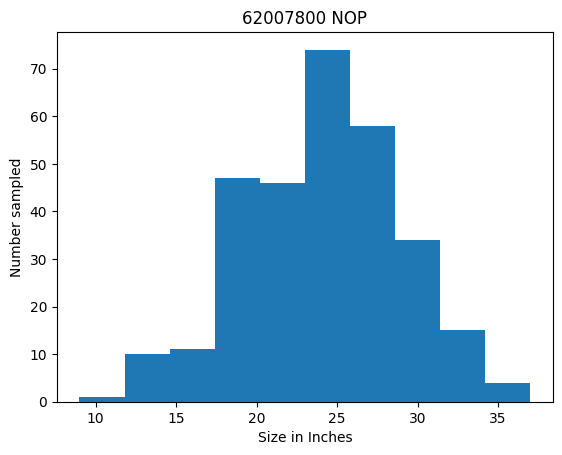

62005700 did not return results for the timeframe or species specified.


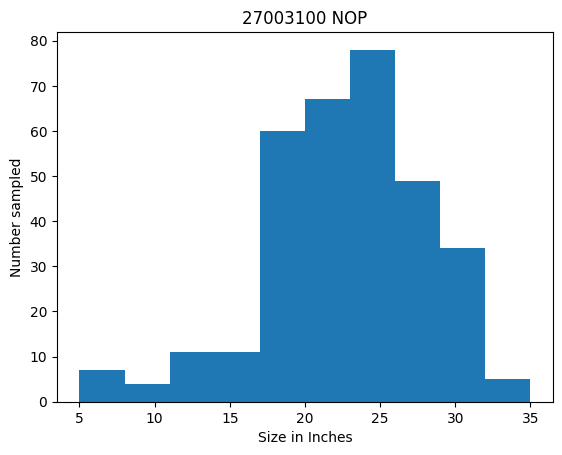

In [21]:
#plot histograms of lengths per lake
plot_length_hist(lengthdict)

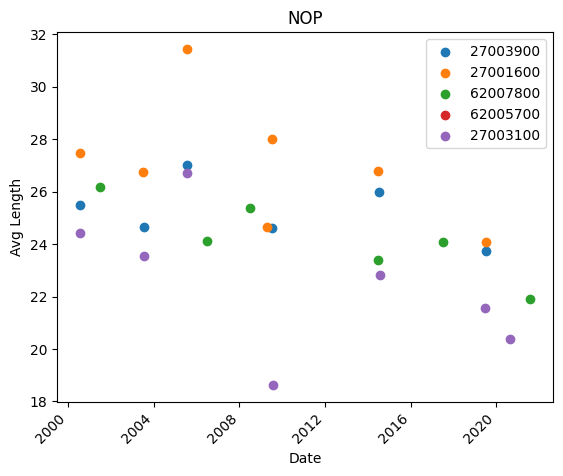

In [22]:
#plot scatter of average fish lengths per lake
plot_scatter(fishavglength, length_sdate, lakes, "Avg Length")

Notes:
Survey Data Empty for 62005700


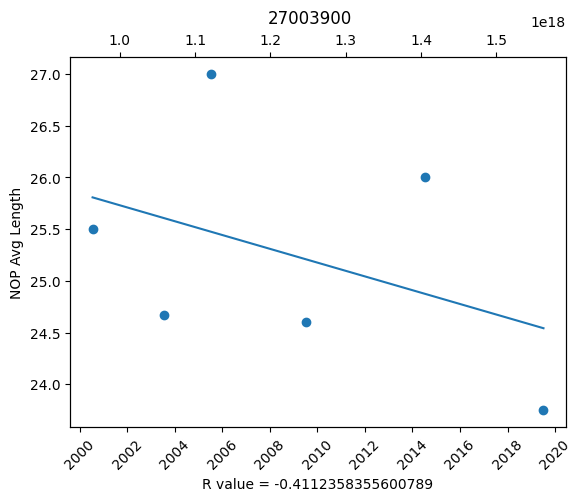

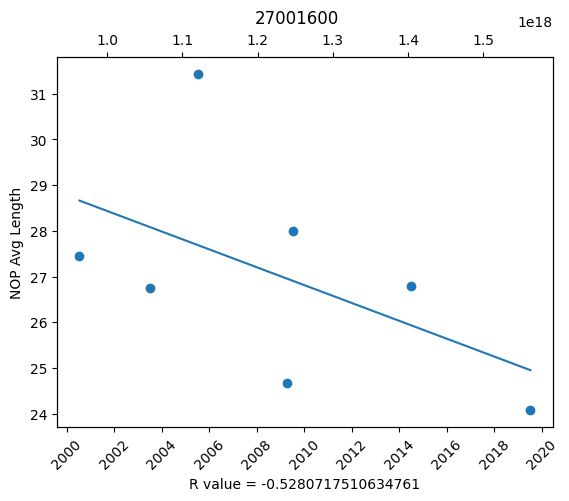

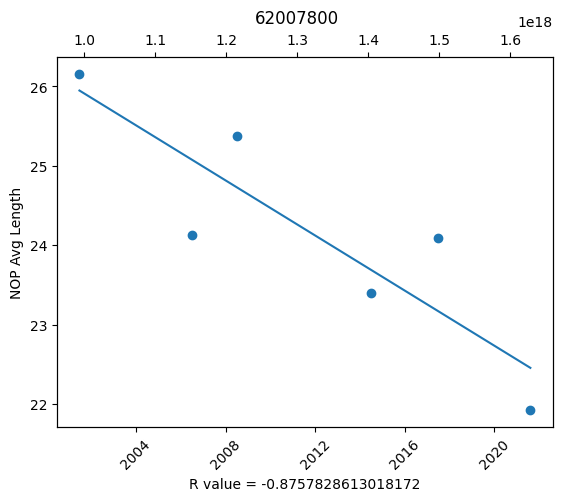

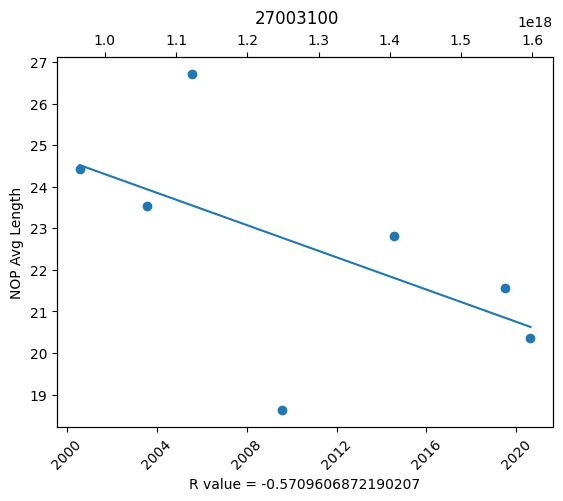

In [23]:
#plot regression lines for each lake average fish length over time
plot_regression_scatter(fishavglength, length_sdate, length_ndate, lakes, "Avg Length")